In [24]:
import os
os.environ["OMP_NUM_THREADS"] = "1"  # 限制OpenMP使用单线程

from sklearn.cluster import KMeans
# 后续代码正常执行

In [26]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# 加载Kaggle数据集
df = pd.read_csv('Mall_Customers.csv')
print(df.head())

# 特征选择与预处理
#无监督不需要划分x，y
X = df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]#年龄，总收入花费目标
#数据标准化
X_scaled = StandardScaler().fit_transform(X)  # 标准化

   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40


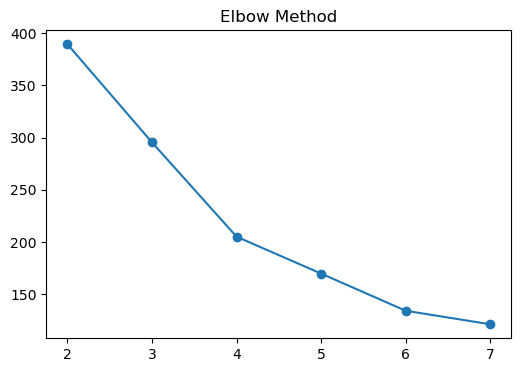

In [28]:
#K-Means聚类（含肘部法则与轮廓系数）
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# 肘部法则确定K值
inertia = []#inertia：保存每个K值的聚类误差平方和（SSE）
for k in range(2, 8):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)#kmeans.inertia_：K-Means模型的属性，表示样本到最近聚类中心的距离平方和

#绘制肘部法则曲线
plt.figure(figsize=(6, 4))
plt.plot(range(2, 8), inertia, marker='o')
plt.title('Elbow Method')

# 选择K=6（根据拐点）
kmeans1 = KMeans(n_clusters=6, random_state=42)
df['Cluster_KMeans'] = kmeans.fit_predict(X_scaled)#拟合模型并返回每个样本的聚类标签（0到4）

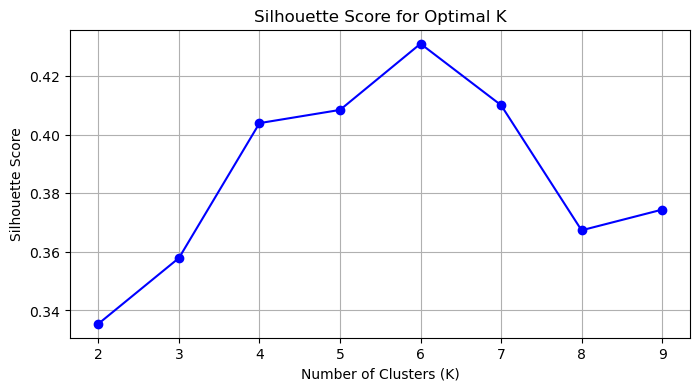

In [30]:
#循环计算 找到最优K值
silhouettes = []
k_range = range(2, 10)
for k in k_range:
    kmeans2 = KMeans(n_clusters=k, random_state=42)
    labels = kmeans2.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouettes.append(score)
plt.figure(figsize=(8, 4))
plt.plot(k_range , silhouettes, marker='o', color='b', linestyle='-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal K')
plt.xticks(k_range)
plt.grid(True)
plt.show()

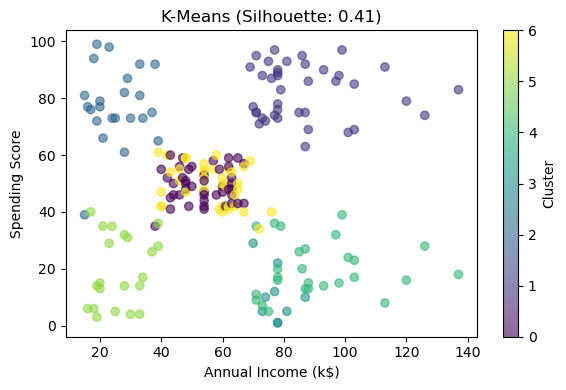

In [32]:
# 以及确定K=6轮廓系数
sil_kmeans = silhouette_score(X_scaled, df['Cluster_KMeans'])

# 可视化（收入 vs 消费评分）
plt.figure(figsize=(6, 4))
plt.scatter(df['Annual Income (k$)'], df['Spending Score (1-100)'], 
            c=df['Cluster_KMeans'], cmap='viridis', alpha=0.6)
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score')
plt.title(f'K-Means (Silhouette: {sil_kmeans:.2f})')
plt.colorbar(label='Cluster')
plt.tight_layout()
plt.show()
#忽略警告
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

噪声点比例: 30.0%


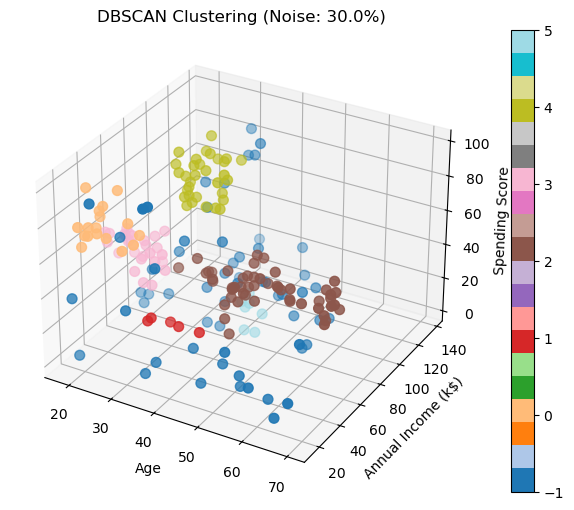

In [34]:
#DBSCAN聚类（自动噪声检测）
from sklearn.cluster import DBSCAN

# DBSCAN参数调优
dbscan = DBSCAN(eps=0.5, min_samples=5)
df['Cluster_DBSCAN'] = dbscan.fit_predict(X_scaled)

# 噪声点分析
noise_ratio = (df['Cluster_DBSCAN'] == -1).mean()
print(f"噪声点比例: {noise_ratio:.1%}")

# 可视化（3D图展示年龄维度）
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(df['Age'], df['Annual Income (k$)'], df['Spending Score (1-100)'], 
                    c=df['Cluster_DBSCAN'], cmap='tab20', s=50)
ax.set_xlabel('Age')
ax.set_ylabel('Annual Income (k$)')
ax.set_zlabel('Spending Score')
plt.title(f'DBSCAN Clustering (Noise: {noise_ratio:.1%})')
plt.colorbar(scatter)
plt.show()

In [36]:
#将K_Means融入监督学习
# 生成哑变量（推荐）
cluster_dummies = pd.get_dummies(df['Cluster_KMeans'], prefix='Cluster')
df = pd.concat([df, cluster_dummies], axis=1)

In [38]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# 特征选择（原始特征 + 聚类标签/哑变量）
cluster_features = ['Age', 'Annual Income (k$)']
features = cluster_features + list(cluster_dummies.columns)
X1 = df[features]
y = df['Spending Score (1-100)']  # 示例预测目标
# 划分数据集
X1_train, X1_test,y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state = 42)

In [40]:
# 训练模型
model = RandomForestRegressor(
    n_estimators=50,
    max_depth=10,           # 增加深度捕捉非线性
    min_samples_leaf=5,     # 防止过拟合
    max_features=0.8,       # 增强泛化性
    random_state=42,
    n_jobs=-1
)
model.fit(X1_train, y_train)

# 评估
print("R² Score:", model.score(X1_test, y_test))

R² Score: 0.8691536549253028


<Axes: >

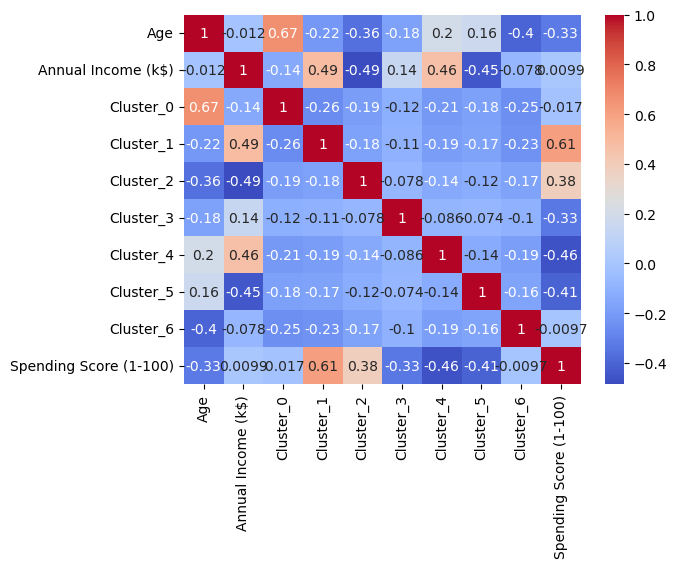

In [42]:
import seaborn as sns
# 计算所有特征与目标变量的相关性
corr_matrix = df[features + ['Spending Score (1-100)']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

Text(0.5, 1.0, 'Feature Importance with Cluster Labels')

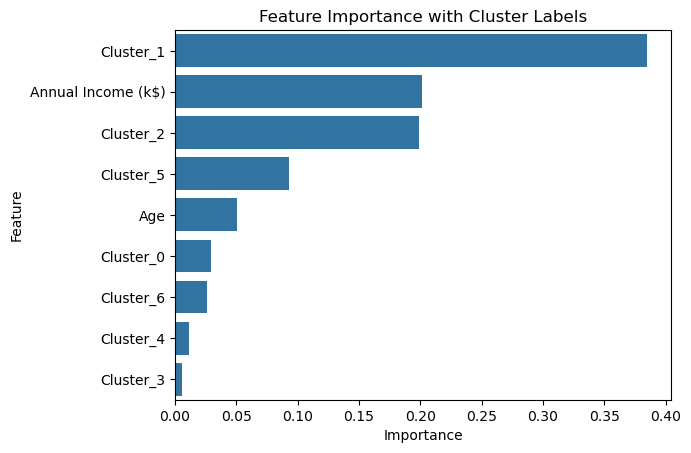

In [44]:
#特征重要性分析
# 获取特征重要性
importance = pd.DataFrame({
    'Feature': features,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

# 可视化
sns.barplot(data=importance, x='Importance', y='Feature')
plt.title('Feature Importance with Cluster Labels')

In [46]:
# 交叉验证验证稳定性
from sklearn.model_selection import cross_validate
cv_results = cross_validate(model, X1, y, cv=5, 
                          scoring=['r2', 'neg_mean_squared_error'])
print("交叉验证R²均值:", cv_results['test_r2'].mean())

交叉验证R²均值: 0.42699604077216147


In [57]:
#计算单个K值的轮廓系数
#验证轮廓系数
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

# 使用K-Means聚类
cluster_labels = kmeans1.fit_predict(df[['Annual Income (k$)', 'Spending Score (1-100)']])

# 计算整体轮廓系数
silhouette_avg = silhouette_score(df[['Annual Income (k$)', 'Spending Score (1-100)']], cluster_labels)
print(f"整体轮廓系数: {silhouette_avg:.3f}")

# 计算每个样本的轮廓系数
sample_silhouette_values = silhouette_samples(df[['Annual Income (k$)', 'Spending Score (1-100)']], cluster_labels)

整体轮廓系数: 0.513


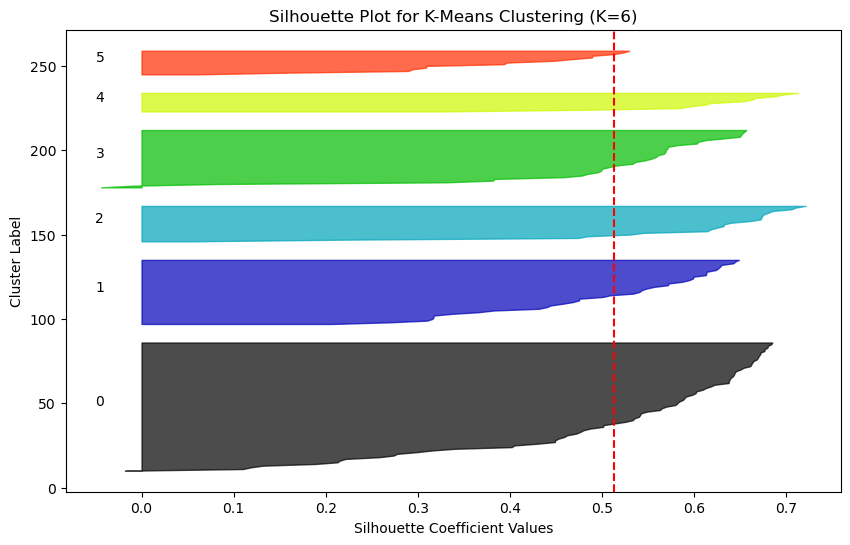

In [63]:
fig, ax = plt.subplots(figsize=(10, 6))
y_lower = 10

for i in range(6):  # 假设K=3
    # 获取第i簇样本的轮廓系数并排序
    ith_cluster_silhouette = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette.sort()
    
    size_cluster_i = ith_cluster_silhouette.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = cm.nipy_spectral(float(i) / 6)  # 颜色映射
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                    0, ith_cluster_silhouette,
                    facecolor=color, edgecolor=color, alpha=0.7)
    
    # 标注簇编号
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

ax.axvline(x=silhouette_avg, color="red", linestyle="--")  # 平均线
ax.set_xlabel("Silhouette Coefficient Values")
ax.set_ylabel("Cluster Label")
plt.title("Silhouette Plot for K-Means Clustering (K=6)")
plt.show()

In [ ]:
#判断高质量簇以及低质量簇